# Task 1 – Visualization of DICOM CT and Manual Segmentations

### Import Modules
Import necessary libraries and internal modules for loading and processing DICOM and segmentation data.

In [1]:

import sys
from pathlib import Path
sys.path.append("../src")

from dicom_loader import load_dicom_series, load_segmentation
from visualization import show_slice, overlay_masks
from config import COLORS
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.ndimage import rotate


### Define Input and Output Paths
Set the paths for the DICOM CT image, the manual segmentation files for liver and tumor, and the directory to save visual results.

In [2]:

image_path = Path("../data/raw/patient_1720/DICOM/31_EQP_Ax5.00mm")
liver_path = Path("../data/raw/patient_1720/SEGMENTATIONS/31_EQP_Ax5.00mm_ManualROI_Liver.dcm")
tumor_path = Path("../data/raw/patient_1720/SEGMENTATIONS/31_EQP_Ax5.00mm_ManualROI_Tumor.dcm")
output_dir = Path("../results/task1")
output_dir.mkdir(parents=True, exist_ok=True)


### Load CT and Segmentation Data
Load the CT image series and the segmentation masks. Combine both masks into a single volume where liver is labeled as 1 and tumor as 2.

In [8]:
ct_volume, slices = load_dicom_series(image_path)
liver_mask = load_segmentation(liver_path)
tumor_mask = load_segmentation(tumor_path)

seg_volume = np.zeros_like(ct_volume, dtype=np.uint8)
seg_volume[:liver_mask.shape[0]][liver_mask > 0] = 1
seg_volume[:tumor_mask.shape[0]][tumor_mask > 0] = 2


### Visualize Individual Slices
Plot selected CT slices along with their corresponding liver and tumor masks using simple intensity maps. A summary figure with 5 axial slices, each showing the CT image and its segmentation overlay (liver in red, tumor in blue).

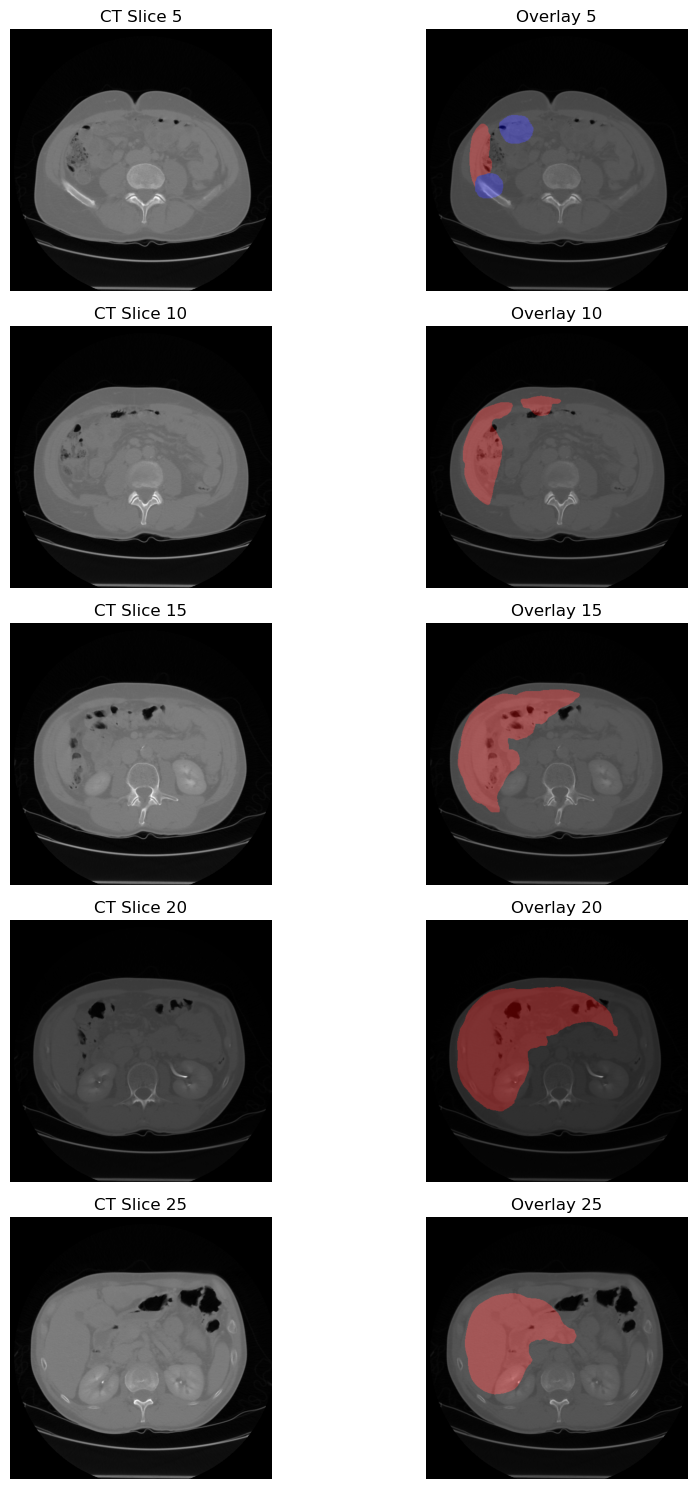

In [4]:
slice_indices = [5, 10, 15, 20, 25]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))

for i, idx in enumerate(slice_indices):
    # CT image
    axes[i, 0].imshow(ct_volume[idx], cmap='gray')
    axes[i, 0].set_title(f"CT Slice {idx}")
    axes[i, 0].axis('off')

    # Mask overlay: liver = red, tumor = blue
    mask_rgb = np.zeros((*seg_volume[idx].shape, 3))
    mask_rgb[seg_volume[idx] == 1] = [1.0, 0.0, 0.0]  # Liver
    mask_rgb[seg_volume[idx] == 2] = [0.0, 0.0, 1.0]  # Tumor

    base = ct_volume[idx].astype(np.float32)
    base = (base - base.min()) / (base.max() - base.min())
    base_rgb = plt.cm.gray(base)[..., :3]
    overlay = base_rgb * 0.7 + mask_rgb * 0.3

    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title(f"Overlay {idx}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig(output_dir / "overview_table_overlay.png")
plt.show()



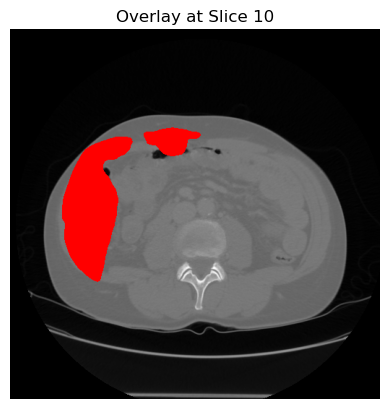

In [5]:

idx = 10
overlay = overlay_masks(ct_volume[idx], seg_volume[idx], class_map=COLORS)
plt.imshow(overlay)
plt.title(f"Overlay at Slice {idx}")
plt.axis('off')
plt.savefig(output_dir / "overlay_slice.png")
plt.show()


The axial slice-wise visualization effectively demonstrates the alignment between the CT anatomy and its corresponding liver and tumor segmentations. In slices 5 to 25, we observe that the liver segmentation (in red) progressively covers the right upper abdominal region, consistent with anatomical expectations. The tumor region (in blue) is distinctly localized and varies in appearance across slices, which suggests proper 3D placement and segmentation integrity. The consistent anatomical positioning and clear contrast between classes validate the success of the segmentation loading and visualization pipeline. This view confirms that the manual annotations are spatially aligned with the CT volume and can be confidently used in further processing or registration tasks.

### Rotational MIP GIF with Segmentation Overlay
The rotating Maximum Intensity Projection (MIP) animation provides an intuitive 3D overview of the anatomical structure and its associated segmentations. By rotating the volume and computing the MIP across coronal views, the liver and tumor masks remain clearly distinguishable throughout the rotation. The red and blue overlays maintain spatial consistency, validating the proper integration and alignment of the masks with the CT volume. Additionally, the anatomical proportions were preserved using the voxel spacing (slice thickness vs. pixel spacing), ensuring a clinically accurate visual representation. This visualization enhances the interpretability of spatial relationships between anatomical structures and lesions, serving as a valuable tool for assessment and presentation.

In [6]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# === Aspect ratio parameters ===
slice_thickness = slices[0].SliceThickness
pixel_spacing = slices[0].PixelSpacing[0]
aspect_ratio = slice_thickness / pixel_spacing

# === MIP function ===
def maximum_intensity_projection(vol, axis=1):
    return np.max(vol, axis=axis)

# === Frame preparation ===
frames = []
angles = np.linspace(0, 360, 36, endpoint=False)  # More steps → smoother rotation

for angle in angles:
    rot_ct = rotate(ct_volume, angle, axes=(1, 2), reshape=False, order=1)
    rot_seg = rotate(seg_volume, angle, axes=(1, 2), reshape=False, order=0)

    mip_ct = maximum_intensity_projection(rot_ct, axis=1)
    mip_seg = maximum_intensity_projection(rot_seg, axis=1)

    mip_ct_norm = (mip_ct - np.min(mip_ct)) / (np.max(mip_ct) - np.min(mip_ct))
    mip_rgb = plt.cm.gray(mip_ct_norm)[..., :3]

    # === Mask overlay ===
    overlay = mip_rgb.copy()
    if np.any(mip_seg == 1):
        overlay[mip_seg == 1] = COLORS["liver"]
    if np.any(mip_seg == 2):
        overlay[mip_seg == 2] = COLORS["tumor"]

    # === Figure without margins ===
    fig = plt.figure(figsize=(5, 5))
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    ax.imshow(overlay)
    ax.axis("off")
    ax.set_aspect(aspect_ratio)
    fig.tight_layout(pad=0)
    canvas.draw()

    buf = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
    w, h = canvas.get_width_height()
    frame = buf.reshape((h, w, 4))[..., :3]
    frames.append(frame)

    plt.close(fig)

# === Save GIF ===
imageio.mimsave(output_dir / "mip_rotation.gif", frames, fps=10)


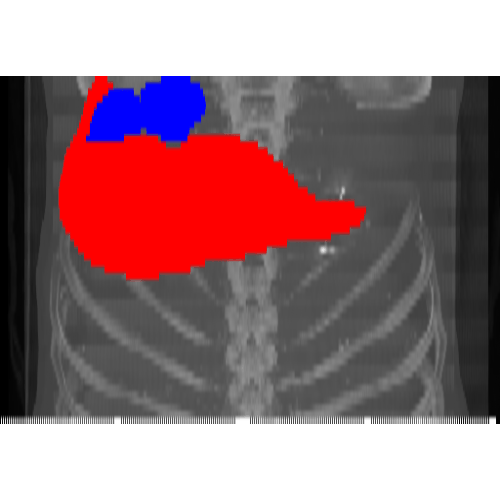

In [7]:
from IPython.display import Image, display
display(Image(filename=str(output_dir / "mip_rotation.gif")))